# Waveform model

Build and train model that takes raw waveforms as input

## Import libraries

In [1]:
import os
import torch
import torch.nn as nn
import torchsummary
import torch.nn.functional as F
import librosa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
from sklearn.metrics import confusion_matrix

## Create custom dataset

In [16]:
SAMPLE_RATE = 16000
FRAME_LENGTH = SAMPLE_RATE  # 1 second per frame (16000 samples at 16 kHz)
FRAME_HOP = FRAME_LENGTH // 2  # 50% overlap between frames

class BirdAudioDataset(Dataset):
    def __init__(self, root_dir, sample_rate=SAMPLE_RATE, frame_length=FRAME_LENGTH, frame_hop=FRAME_HOP, transform=None):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_hop = frame_hop
        self.transform = transform
        self.audio_paths = []
        self.labels = []
        self.label_encoder = LabelEncoder()
        
        # Load audio file paths and labels
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for file_name in os.listdir(label_dir)[:100]:
                    if file_name.endswith(".wav") or file_name.endswith(".mp3"):
                        self.audio_paths.append(os.path.join(label_dir, file_name))
                        self.labels.append(label)
        
        # Encode labels (it assumes that in all directories there will be the same directories in the same order)
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]

        try:
            waveform, sr = librosa.load(audio_path, sr=self.sample_rate)  # Resamples to sample_rate if needed
        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            return None

        max_length = self.sample_rate * 20  # 20 seconds
        if waveform.shape[0] > max_length:
            waveform = waveform[:max_length]
            
        waveform = torch.tensor(waveform)

        # Ensure the waveform is at least as long as the frame_length
        if waveform.shape[0] < self.frame_length:
            # Pad or truncate the waveform if it's too short (use padding_value=0)
            waveform = F.pad(waveform, (0, self.frame_length - waveform.shape[0]))

        # Split waveform into frames with specified length and hop
        frames = waveform.unfold(dimension=0, size=self.frame_length, step=self.frame_hop)
        
        # Apply any additional transform
        if self.transform:
            frames = self.transform(frames)

        return frames, label

## Model

### Model definition

In [17]:
class BirdClassifierCNN(nn.Module):
    def __init__(self, num_classes, frame_length=16000):
        super().__init__()
        
        self.frame_length = frame_length

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * (frame_length // 64), 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, num_frames, frame_length)
        batch_size, num_frames, frame_length = x.size()

        # Reshape for processing each frame independently
        frames = x.view(batch_size * num_frames, 1, frame_length)

        # Get predictions for each frame
        frame_features = self.feature_extractor(frames)
        frame_predictions = self.classifier(frame_features)

        # Reshape back to (batch_size, num_frames, num_classes)
        frame_predictions = frame_predictions.view(batch_size, num_frames, -1)

        # Average predictions across frames (handles variable-length inputs)
        sample_predictions = frame_predictions.mean(dim=1)
        
        return sample_predictions

### Implement training and validation

In [18]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=5, min_delta=0.0, path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """
        Saves model when validation loss decreases.
        """
        torch.save(model.state_dict(), self.path)
        print("Validation loss decreased. Saving model...\n")

In [19]:
def train_step(model, data_loader, loss_fn, optimizer, device):
    """
    Perform a single training step on the dataset.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(data_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    
    return epoch_loss, epoch_acc

def val_step(model, data_loader, loss_fn, device):
    """
    Perform a single validation step on the dataset.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    
    return epoch_loss, epoch_acc

def train_model(model, dataloaders, loss_fn, optimizer, device='cpu', num_epochs=10, patience=5, min_delta=0.0):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    BEST_MODEL_PATH = Path('./wav_model.pth')
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta, path=BEST_MODEL_PATH)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Training step
        train_loss, train_acc = train_step(model, dataloaders['train'], loss_fn, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validation step
        val_loss, val_acc = val_step(model, dataloaders['val'], loss_fn, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")

        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load the best model after training stops
    model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))

    return {'train_losses': train_losses, 'val_losses': val_losses, 'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies}

In [20]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
DATA_DIR = Path('../data/xeno-canto/')
train_dir = DATA_DIR / 'train'
val_dir = DATA_DIR / 'val'
test_dir = DATA_DIR / 'test'

### Pad elements in batches

In [23]:
def collate_fn(batch):
    """
    Custom collate function to pad variable-length sequences in the batch.
    """
    # Filter out None values (failed loading items)
    batch = [item for item in batch if item is not None]

    if not batch:  # If no valid samples remain, return empty tensors
        return torch.zeros(1, 1, 1), torch.zeros(1, dtype=torch.long)

    inputs, labels = zip(*batch)
    
    # Pad the inputs to the length of the longest sequence in the batch
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)  # Pad sequences to max length

    # Convert labels to a tensor
    labels = torch.tensor(labels)
    
    return inputs, labels

### Create Datasets and Dataloaders

In [24]:
BATCH_SIZE = 8

train_dataset = BirdAudioDataset(root_dir=train_dir, sample_rate=SAMPLE_RATE)
val_dataset = BirdAudioDataset(root_dir=val_dir, sample_rate=SAMPLE_RATE)
test_dataset = BirdAudioDataset(root_dir=test_dir, sample_rate=SAMPLE_RATE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, pin_memory=True)
dataloaders = {'train': train_loader, 'val': val_loader}

### Create model

In [25]:
num_classes = len(train_dataset.label_encoder.classes_)
model = BirdClassifierCNN(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
torchsummary.summary(model, (25, 16000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 8000]              96
              ReLU-2             [-1, 16, 8000]               0
         MaxPool1d-3             [-1, 16, 4000]               0
            Conv1d-4             [-1, 32, 2000]           2,592
              ReLU-5             [-1, 32, 2000]               0
         MaxPool1d-6             [-1, 32, 1000]               0
            Conv1d-7              [-1, 64, 500]          10,304
              ReLU-8              [-1, 64, 500]               0
         MaxPool1d-9              [-1, 64, 250]               0
          Flatten-10                [-1, 16000]               0
          Dropout-11                [-1, 16000]               0
           Linear-12                  [-1, 256]       4,096,256
             ReLU-13                  [-1, 256]               0
           Linear-14                   

## Training

In [28]:
results = train_model(model, dataloaders, loss_fn, optimizer, device, num_epochs=40)

Epoch 1/40
----------


Training:   3%|▎         | 6/238 [00:10<06:40,  1.73s/it]C:\Users\micha\AppData\Local\Temp\ipykernel_12948\3265162127.py:36: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(audio_path, sr=self.sample_rate)  # Resamples to sample_rate if needed
c:\Users\micha\miniconda3\envs\birddetect\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Training: 100%|██████████| 238/238 [07:55<00:00,  2.00s/it]


Train Loss: 2.9880 Acc: 0.0458


Validation: 100%|██████████| 199/199 [06:31<00:00,  1.97s/it]


Val Loss: 2.9679 Acc: 0.0597

Validation loss decreased. Saving model...

Epoch 2/40
----------


Training: 100%|██████████| 238/238 [07:35<00:00,  1.91s/it]


Train Loss: 2.9778 Acc: 0.0390


Validation: 100%|██████████| 199/199 [06:26<00:00,  1.94s/it]


Val Loss: 2.9533 Acc: 0.0629

Validation loss decreased. Saving model...

Epoch 3/40
----------


Training: 100%|██████████| 238/238 [07:35<00:00,  1.91s/it]


Train Loss: 2.9667 Acc: 0.0511


Validation: 100%|██████████| 199/199 [06:25<00:00,  1.94s/it]


Val Loss: 2.9695 Acc: 0.0742

Epoch 4/40
----------


Training: 100%|██████████| 238/238 [07:34<00:00,  1.91s/it]


Train Loss: 2.9560 Acc: 0.0595


Validation: 100%|██████████| 199/199 [06:26<00:00,  1.94s/it]


Val Loss: 2.9728 Acc: 0.0629

Epoch 5/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.90s/it]


Train Loss: 2.9741 Acc: 0.0616


Validation: 100%|██████████| 199/199 [06:31<00:00,  1.97s/it]


Val Loss: 2.9499 Acc: 0.0635

Validation loss decreased. Saving model...

Epoch 6/40
----------


Training: 100%|██████████| 238/238 [07:35<00:00,  1.91s/it]


Train Loss: 3.0151 Acc: 0.0579


Validation: 100%|██████████| 199/199 [06:25<00:00,  1.94s/it]


Val Loss: 2.9542 Acc: 0.0597

Epoch 7/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.90s/it]


Train Loss: 2.9700 Acc: 0.0700


Validation: 100%|██████████| 199/199 [06:26<00:00,  1.94s/it]


Val Loss: 2.9494 Acc: 0.0635

Validation loss decreased. Saving model...

Epoch 8/40
----------


Training: 100%|██████████| 238/238 [07:37<00:00,  1.92s/it]


Train Loss: 2.9708 Acc: 0.0700


Validation: 100%|██████████| 199/199 [06:22<00:00,  1.92s/it]


Val Loss: 2.9569 Acc: 0.0453

Epoch 9/40
----------


Training: 100%|██████████| 238/238 [07:31<00:00,  1.90s/it]


Train Loss: 2.9241 Acc: 0.0742


Validation: 100%|██████████| 199/199 [06:22<00:00,  1.92s/it]


Val Loss: 2.9018 Acc: 0.0867

Validation loss decreased. Saving model...

Epoch 10/40
----------


Training: 100%|██████████| 238/238 [07:34<00:00,  1.91s/it]


Train Loss: 2.8430 Acc: 0.0974


Validation: 100%|██████████| 199/199 [06:27<00:00,  1.95s/it]


Val Loss: 2.9517 Acc: 0.0761

Epoch 11/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.90s/it]


Train Loss: 2.8068 Acc: 0.1074


Validation: 100%|██████████| 199/199 [06:25<00:00,  1.94s/it]


Val Loss: 2.7648 Acc: 0.1345

Validation loss decreased. Saving model...

Epoch 12/40
----------


Training: 100%|██████████| 238/238 [07:34<00:00,  1.91s/it]


Train Loss: 2.7421 Acc: 0.1269


Validation: 100%|██████████| 199/199 [06:24<00:00,  1.93s/it]


Val Loss: 2.8475 Acc: 0.0949

Epoch 13/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.90s/it]


Train Loss: 2.7042 Acc: 0.1464


Validation: 100%|██████████| 199/199 [06:25<00:00,  1.94s/it]


Val Loss: 2.8668 Acc: 0.1238

Epoch 14/40
----------


Training: 100%|██████████| 238/238 [07:40<00:00,  1.94s/it]


Train Loss: 2.6109 Acc: 0.2001


Validation: 100%|██████████| 199/199 [06:28<00:00,  1.95s/it]


Val Loss: 2.7339 Acc: 0.1389

Validation loss decreased. Saving model...

Epoch 15/40
----------


Training: 100%|██████████| 238/238 [07:50<00:00,  1.98s/it]


Train Loss: 2.4392 Acc: 0.2475


Validation: 100%|██████████| 199/199 [06:37<00:00,  2.00s/it]


Val Loss: 2.7450 Acc: 0.1666

Epoch 16/40
----------


Training: 100%|██████████| 238/238 [07:35<00:00,  1.91s/it]


Train Loss: 2.3341 Acc: 0.2728


Validation: 100%|██████████| 199/199 [06:28<00:00,  1.95s/it]


Val Loss: 2.8827 Acc: 0.1967

Epoch 17/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.91s/it]


Train Loss: 2.1934 Acc: 0.3407


Validation: 100%|██████████| 199/199 [06:25<00:00,  1.94s/it]


Val Loss: 2.5752 Acc: 0.2722

Validation loss decreased. Saving model...

Epoch 18/40
----------


Training: 100%|██████████| 238/238 [07:32<00:00,  1.90s/it]


Train Loss: 2.1219 Acc: 0.3907


Validation: 100%|██████████| 199/199 [06:29<00:00,  1.96s/it]


Val Loss: 2.5800 Acc: 0.2640

Epoch 19/40
----------


Training: 100%|██████████| 238/238 [07:36<00:00,  1.92s/it]


Train Loss: 1.9102 Acc: 0.4313


Validation: 100%|██████████| 199/199 [06:25<00:00,  1.94s/it]


Val Loss: 2.5304 Acc: 0.3105

Validation loss decreased. Saving model...

Epoch 20/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.91s/it]


Train Loss: 1.7468 Acc: 0.4866


Validation: 100%|██████████| 199/199 [06:24<00:00,  1.93s/it]


Val Loss: 2.4165 Acc: 0.3306

Validation loss decreased. Saving model...

Epoch 21/40
----------


Training: 100%|██████████| 238/238 [07:32<00:00,  1.90s/it]


Train Loss: 1.5820 Acc: 0.5245


Validation: 100%|██████████| 199/199 [06:26<00:00,  1.94s/it]


Val Loss: 2.5749 Acc: 0.3338

Epoch 22/40
----------


Training: 100%|██████████| 238/238 [07:38<00:00,  1.93s/it]


Train Loss: 1.5497 Acc: 0.5592


Validation: 100%|██████████| 199/199 [06:26<00:00,  1.94s/it]


Val Loss: 2.7973 Acc: 0.3281

Epoch 23/40
----------


Training: 100%|██████████| 238/238 [07:37<00:00,  1.92s/it]


Train Loss: 1.6108 Acc: 0.5893


Validation: 100%|██████████| 199/199 [06:27<00:00,  1.95s/it]


Val Loss: 2.4903 Acc: 0.3369

Epoch 24/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.91s/it]


Train Loss: 1.3725 Acc: 0.6035


Validation: 100%|██████████| 199/199 [06:27<00:00,  1.95s/it]


Val Loss: 2.4254 Acc: 0.3803

Epoch 25/40
----------


Training: 100%|██████████| 238/238 [07:38<00:00,  1.93s/it]


Train Loss: 1.2730 Acc: 0.6351


Validation: 100%|██████████| 199/199 [06:26<00:00,  1.94s/it]


Val Loss: 2.3776 Acc: 0.3997

Validation loss decreased. Saving model...

Epoch 26/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.90s/it]


Train Loss: 1.1399 Acc: 0.6682


Validation: 100%|██████████| 199/199 [06:30<00:00,  1.96s/it]


Val Loss: 2.5905 Acc: 0.3564

Epoch 27/40
----------


Training: 100%|██████████| 238/238 [07:37<00:00,  1.92s/it]


Train Loss: 1.1215 Acc: 0.6735


Validation: 100%|██████████| 199/199 [06:29<00:00,  1.96s/it]


Val Loss: 2.5173 Acc: 0.4261

Epoch 28/40
----------


Training: 100%|██████████| 238/238 [07:36<00:00,  1.92s/it]


Train Loss: 1.1179 Acc: 0.6851


Validation: 100%|██████████| 199/199 [06:26<00:00,  1.94s/it]


Val Loss: 2.4263 Acc: 0.4123

Epoch 29/40
----------


Training: 100%|██████████| 238/238 [07:34<00:00,  1.91s/it]


Train Loss: 1.0443 Acc: 0.7162


Validation: 100%|██████████| 199/199 [06:26<00:00,  1.94s/it]


Val Loss: 2.5486 Acc: 0.4067

Epoch 30/40
----------


Training: 100%|██████████| 238/238 [07:33<00:00,  1.91s/it]


Train Loss: 0.9242 Acc: 0.7457


Validation: 100%|██████████| 199/199 [06:46<00:00,  2.04s/it]

Val Loss: 2.4554 Acc: 0.4500

Early stopping triggered


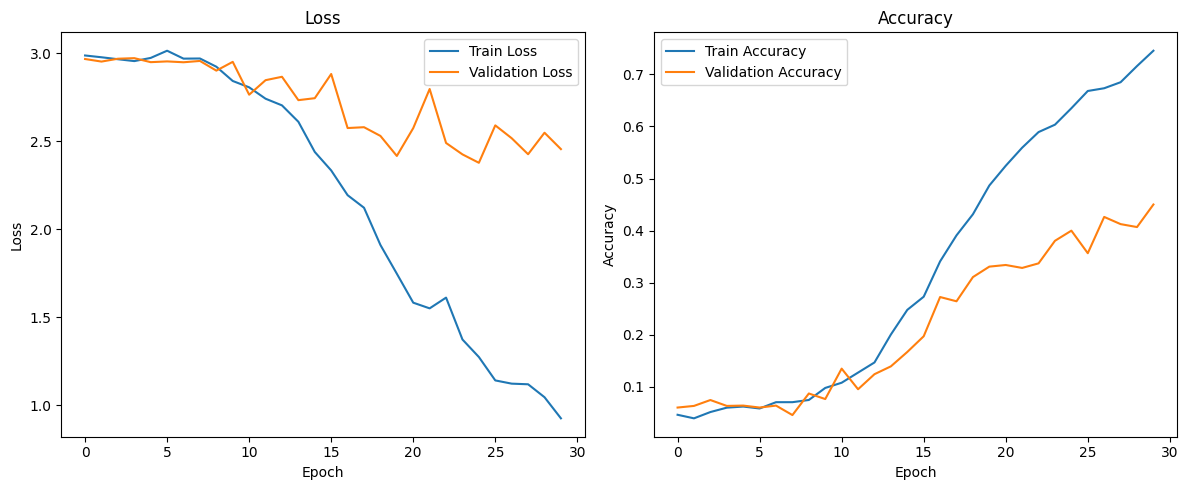

In [29]:
plot_training(results['train_losses'], results['val_losses'], results['train_accuracies'], results['val_accuracies'])